# 计算二维熵密度分布

### $$\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$$

In [1]:
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt

import mplhep as hep
hep.style.use('ATLAS')

In [2]:
class EntropyProcessor:
    def __init__(self, base_path, output_path, grid_size=200, sigma=1.0):
        """
        初始化熵处理器
        :param base_path: 原始事件数据的根目录（每个事件有一个event_x文件夹）
        :param output_path: 输出熵密度文件的目录
        :param grid_size: 网格的尺寸（grid_size x grid_size）
        :param sigma: 高斯函数的标准差，用于计算核子分布
        """
        self.base_path = base_path
        self.output_path = output_path
        self.grid_size = grid_size
        self.sigma = sigma

        # 构建静态二维网格坐标（用于每个事件的熵计算）
        self.x_range = np.linspace(-10, 10, self.grid_size)
        self.y_range = np.linspace(-10, 10, self.grid_size)
        x_grid, y_grid = np.meshgrid(self.x_range, self.y_range)
        self.grid_points = np.stack([x_grid, y_grid], axis=-1)

    def gaussian_sum(self, x_l, xi_list, distance_threshold=5):
        """
        对一个网格点 x_l，计算其附近核子位置 xi_list 上的高斯加权和
        :param x_l: 当前网格点坐标
        :param xi_list: 所有核子的位置列表（每个元素是np.array([x, y])）
        :param distance_threshold: 忽略远离x_l的核子以加快计算
        :return: 熵密度值（高斯核加权和）
        """
        sum_value = 0
        for xi in xi_list:
            distance = np.linalg.norm(x_l - xi)
            if distance <= distance_threshold:
                sum_value += np.exp(-np.sum((x_l - xi)**2) / (2 * self.sigma**2))
        return sum_value

    def evaluate_gaussian_sum_on_grid(self, xi_list):
        """
        对整个网格计算所有点的熵密度（二维矩阵）
        :param xi_list: 核子位置列表
        :return: 网格上每个点的高斯熵密度值（二维数组）
        """
        result = np.zeros((self.grid_size, self.grid_size))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                result[i, j] = self.gaussian_sum(self.grid_points[i, j], xi_list)
        return result

    def read_positions(self, file_path):
        """
        读取 position_of_projectile.dat 或 position_of_target.dat 中的核子位置
        :param file_path: 输入文件路径
        :return: 核子二维位置的列表 [array([x, y]), ...]
        """
        data = np.loadtxt(file_path)
        if data.ndim == 1:
            data = data.reshape(-1, 2)
        elif data.shape[1] != 2:
            raise ValueError(f"{file_path} 每行必须包含两个数值（x y）")
        return [np.array([x, y]) for x, y in data]

    def ensure_directory_exists(self, directory):
        """
        确保输出目录存在
        :param directory: 目录路径
        """
        if not os.path.exists(directory):
            os.makedirs(directory)

    def save_results(self, filename, result):
        """
        保存熵密度二维数组为文本文件
        :param filename: 保存的文件名（例如 projectile_entropy_event_0.dat）
        :param result: 熵密度二维数组
        """
        self.ensure_directory_exists(self.output_path)
        filepath = os.path.join(self.output_path, filename)
        np.savetxt(filepath, result)

    def process_single_event(self, event):
        """
        处理单个事件：读取核子位置、计算熵密度、保存结果
        :param event: 事件编号（如0, 1, ..., 49999）
        """
        try:
            event_dir = os.path.join(self.base_path, f"event_{event}")
            target_file = os.path.join(event_dir, "position_of_target.dat")
            projectile_file = os.path.join(event_dir, "position_of_projectile.dat")

            target_xi = self.read_positions(target_file)
            proj_xi = self.read_positions(projectile_file)

            # 分别计算目标核与投射核的熵密度分布
            target_result = self.evaluate_gaussian_sum_on_grid(target_xi)
            proj_result = self.evaluate_gaussian_sum_on_grid(proj_xi)

            # 保存熵密度分布结果
            self.save_results(f"target_entropy_event_{event}.dat", target_result)
            self.save_results(f"projectile_entropy_event_{event}.dat", proj_result)

        except Exception as e:
            print(f"[事件 {event}] 出错：{e}")

    def process_all_events_parallel(self, total_events=50000, num_workers=8):
        """
        并行处理所有事件并显示 tqdm 进度条
        :param total_events: 要处理的事件总数（默认50000）
        :param num_workers: 并行进程数（建议与你的CPU核心数一致或稍低）
        """
        print(f"开始并行处理 {total_events} 个事件，使用 {num_workers} 个进程。")

        with Pool(processes=num_workers) as pool:
            # 使用 tqdm 显示进度条，随着每个事件处理完成更新
            with tqdm(total=total_events, desc="Processing Events") as pbar:
                for _ in pool.imap_unordered(self.process_single_event, range(total_events)):
                    pbar.update(1)

        print("全部事件处理完成。")


In [3]:
# 初始化处理器并运行
processor = EntropyProcessor(
    base_path="/media/mengzhu/MZ/d_Au_work/d_Au_DWF/information_of_d_Au_collision",
    output_path="/media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy2d",
    grid_size=200,   # 可调分辨率
    sigma=1.0        # 高斯平滑参数
)

# 并行运行，建议将 num_workers 设置为你的 CPU 核心数
processor.process_all_events_parallel(total_events=50000, num_workers=16)


开始并行处理 50000 个事件，使用 16 个进程。


Processing Events: 100%|████████████████| 50000/50000 [47:31<00:00, 17.54it/s]

全部事件处理完成。


### 验证计算得到的entropy2d图像的是否与上面的计算结果一致

In [13]:
def plot_saved_entropy(event=0, save_fig=False):
    """
    读取并绘制已保存的熵密度数据（projectile + target）

    参数:
        event (int): 事件编号
        entropy_data_path (str): 熵密度数据的目录路径（包含 .dat 文件）
        output_fig_path (str): 图片保存路径（目录）
        save_fig (bool): 是否保存为PDF图像
    """
    entropy_data_path = "/media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy2d/"
    output_fig_path = "/home/mengzhu/mywork/d_Au_work/fig/"

    # 构造文件路径
    projectile_file = os.path.join(entropy_data_path, f"projectile_entropy_event_{event}.dat")
    target_file = os.path.join(entropy_data_path, f"target_entropy_event_{event}.dat")

    # 加载数据
    try:
        proj_result = np.loadtxt(projectile_file)
        target_result = np.loadtxt(target_file)
    except Exception as e:
        print(f"读取事件 {event} 的熵密度数据失败: {e}")
        return

    # 设置字体大小
    title_fontsize = 22
    label_fontsize = 18

    # 创建画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 物理坐标范围
    extent = [-10, 10, -10, 10]  # xmin, xmax, ymin, ymax [fm]

    # 投射核图像
    c1 = ax1.imshow(proj_result, cmap='hot', aspect='equal', extent=extent, origin='lower')
    fig.colorbar(c1, ax=ax1, label='Gaussian Sum')
    ax1.set_title('The 2D Entropy Distribution of projectile', fontsize=label_fontsize)
    ax1.set_xlabel('X [fm]', fontsize=label_fontsize, ha='center')
    ax1.set_ylabel('Y [fm]', fontsize=label_fontsize, ha='center')
    ax1.set_aspect('equal')

    # 目标核图像
    c2 = ax2.imshow(target_result, cmap='hot', aspect='equal', extent=extent, origin='lower')
    fig.colorbar(c2, ax=ax2, label='Gaussian Sum')
    ax2.set_title('The 2D Entropy Distribution of target', fontsize=label_fontsize)
    ax2.set_xlabel('X [fm]', fontsize=label_fontsize, ha='center')
    ax2.set_ylabel('Y [fm]', fontsize=label_fontsize, ha='center')
    ax2.set_aspect('equal')

    # 整体标题
    plt.tight_layout(rect=[0.05, 0, 0.95, 0.9])
    plt.suptitle(f'The 2D Entropy Distribution in Event_{event}', fontsize=title_fontsize)

    # 保存图像
    if save_fig:
        ensure_directory_exists(output_fig_path)
        save_path = os.path.join(output_fig_path, f'heatmap_event_{event}.pdf')
        plt.savefig(save_path)
        print(f"图像已保存至: {save_path}")

    # 显示图像
    plt.show()

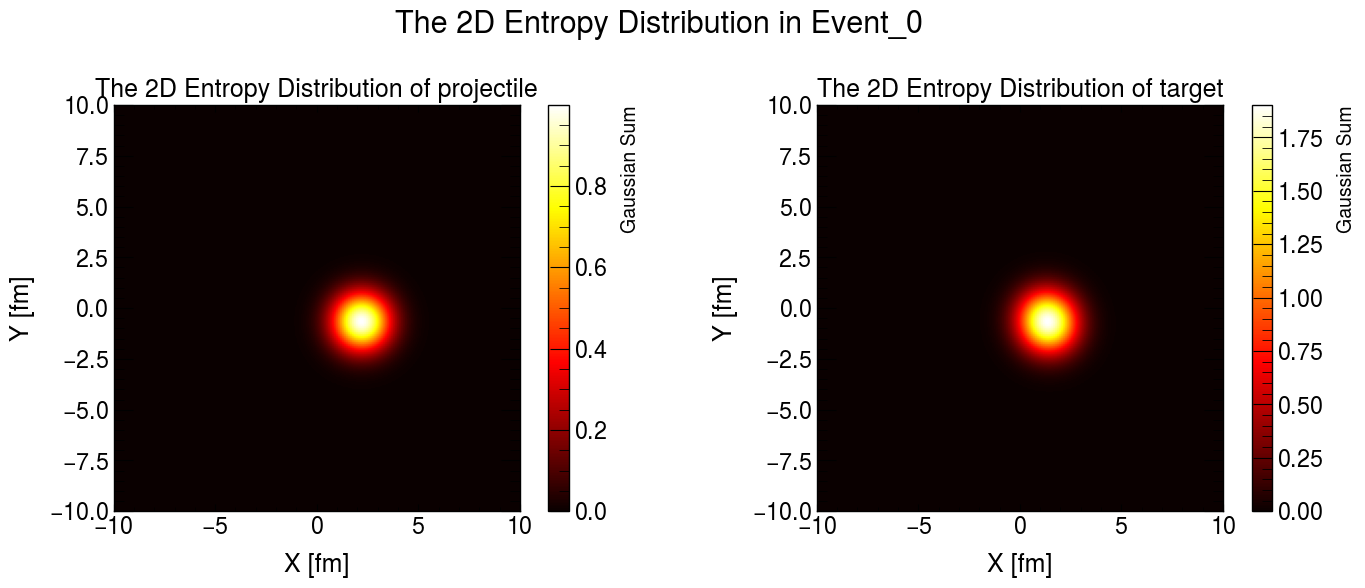

In [17]:
plot_saved_entropy(event=0, save_fig=False)

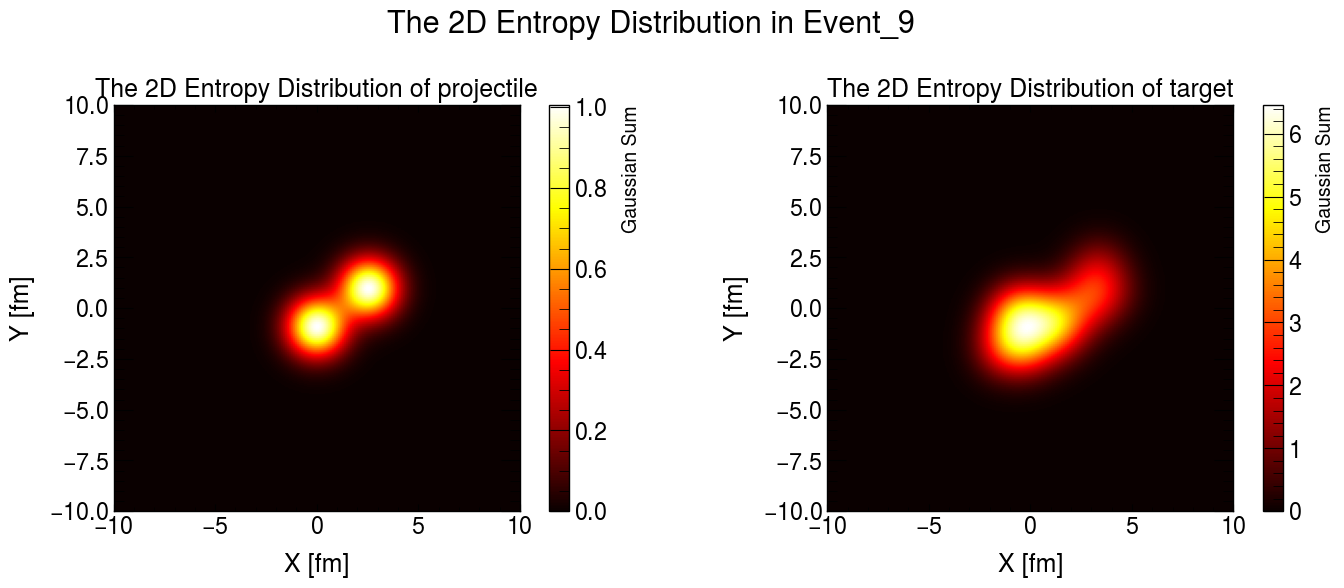

In [18]:
plot_saved_entropy(event=9, save_fig=False)

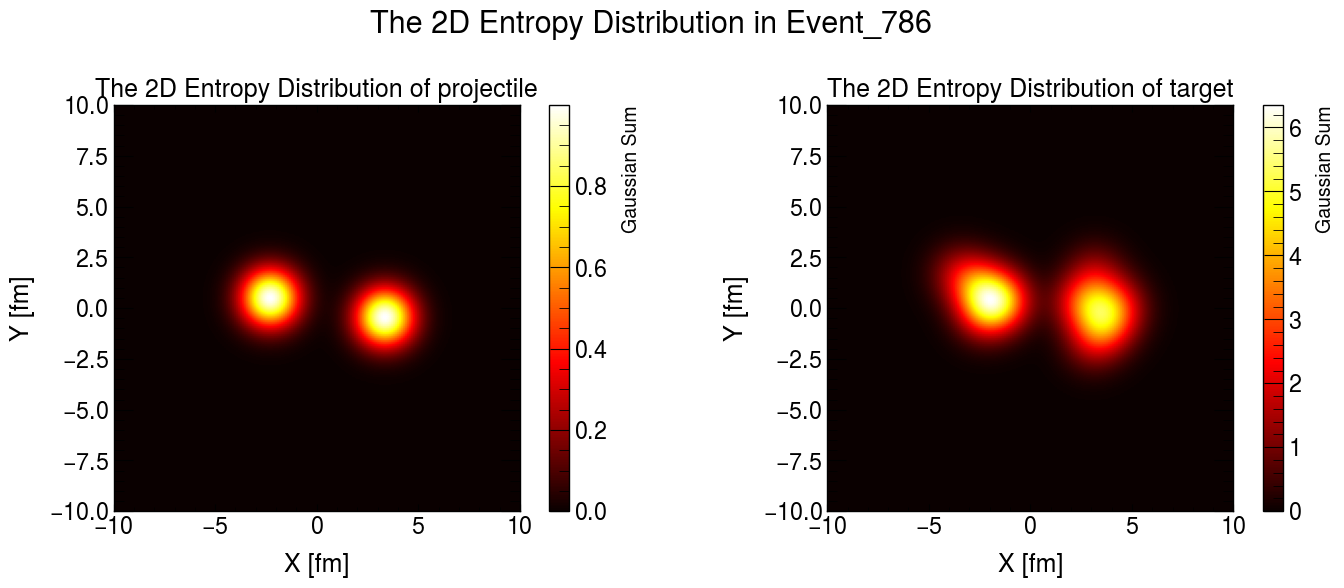

In [19]:
plot_saved_entropy(event=786, save_fig=False)